<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/XgBoost_PJME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hourly Energy Consumption Prediction

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('https://raw.githubusercontent.com/archd3sai/Hourly-Energy-Consumption-Prediction/master/PJME_hourly.csv', index_col = [0], parse_dates = [0])

In [3]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


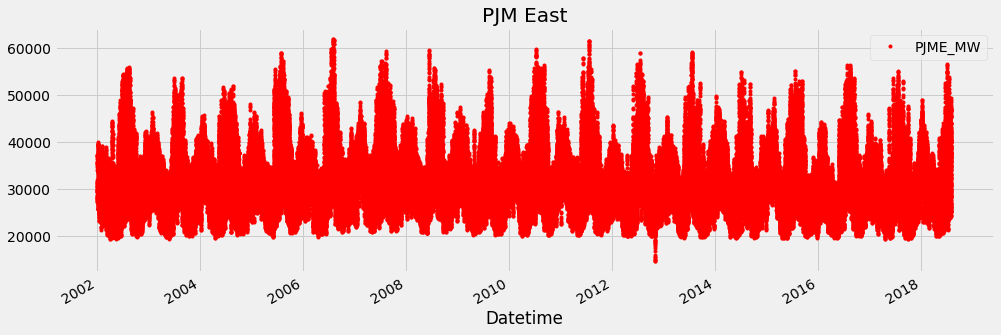

In [4]:
pjme.plot(style = '.' , color = "red", figsize = (15,5), title = "PJM East");

## EDA

Let's create time series features from datetime index

In [5]:
pjme['date'] = pjme.index
pjme['hour'] = pjme['date'].dt.hour
pjme['dayofweek'] = pjme['date'].dt.dayofweek
pjme['quarter'] = pjme['date'].dt.quarter
pjme['month'] = pjme['date'].dt.month
pjme['year'] = pjme['date'].dt.year
pjme['dayofyear'] = pjme['date'].dt.dayofyear
pjme['dayofmonth'] = pjme['date'].dt.day
pjme['weekofyear'] = pjme['date'].dt.weekofyear
pjme.drop(['date'], axis = 1, inplace=True)

<ipython-input-5-14c82bd8ae6e>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  pjme['weekofyear'] = pjme['date'].dt.weekofyear


In [6]:
pjme.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


In [7]:
pjme.isna().sum(axis = 0)

PJME_MW       0
hour          0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


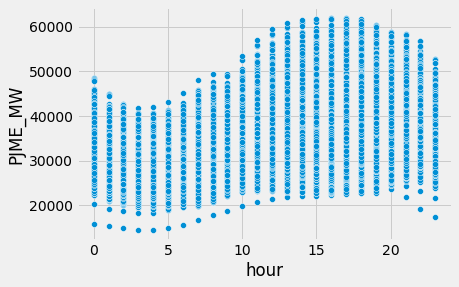

In [8]:
sns.scatterplot('hour','PJME_MW', data=pjme)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


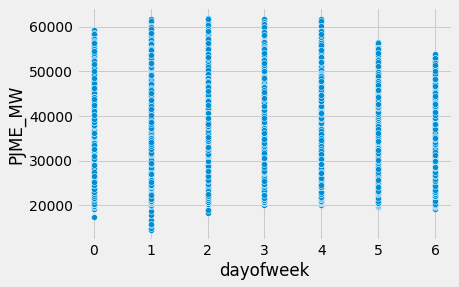

In [9]:
sns.scatterplot('dayofweek','PJME_MW', data=pjme)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


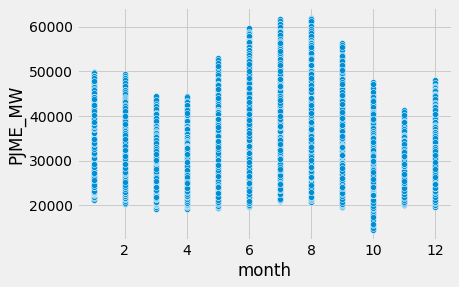

In [10]:
sns.scatterplot('month','PJME_MW', data=pjme)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([2000. , 2002.5, 2005. , 2007.5, 2010. , 2012.5, 2015. , 2017.5,
        2020. ]), <a list of 9 Text major ticklabel objects>)

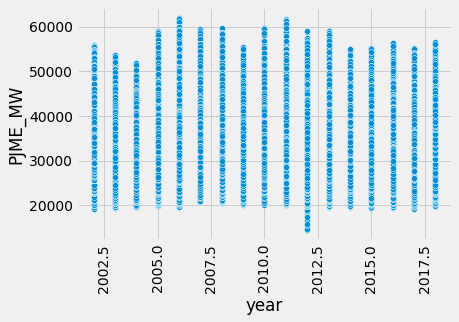

In [11]:
sns.scatterplot('year','PJME_MW', data=pjme)
plt.xticks(rotation = 'vertical')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


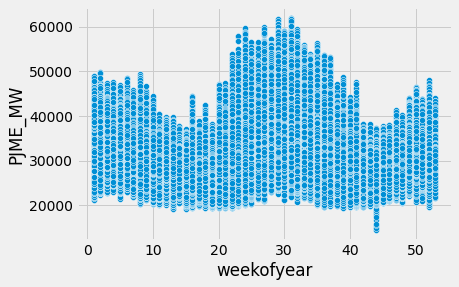

In [12]:
sns.scatterplot('weekofyear','PJME_MW', data=pjme)

## Train-Test Split

Cut off the data after 2015 to use as our validation set.

In [13]:
pjme_train = pjme.loc[pjme.year < 2015]
pjme_test = pjme.loc[pjme.year >= 2015]

In [14]:
pjme_train.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2014-01-01 20:00:00,36193.0,20,2,1,1,2014,1,1,1
2014-01-01 21:00:00,35601.0,21,2,1,1,2014,1,1,1
2014-01-01 22:00:00,34242.0,22,2,1,1,2014,1,1,1
2014-01-01 23:00:00,32215.0,23,2,1,1,2014,1,1,1
2014-01-02 00:00:00,30159.0,0,3,1,1,2014,2,2,1


In [15]:
pjme_test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,53


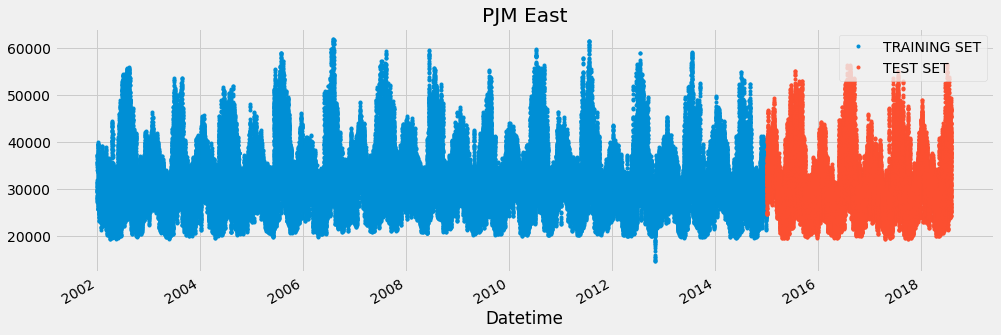

In [16]:
(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'})).append(pjme_test.rename(columns={'PJME_MW': 'TEST SET'}), sort = False)[['TRAINING SET','TEST SET']].plot(style='.', figsize = (15,5), title = "PJM East");

In [17]:
x_train = pjme_train[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
x_test = pjme_test[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
y_train = pjme_train[['PJME_MW']]
y_test = pjme_test[['PJME_MW']]

## XG Boost Model

In [18]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [19]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(x_train, y_train,
       eval_set = [(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[11:09:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

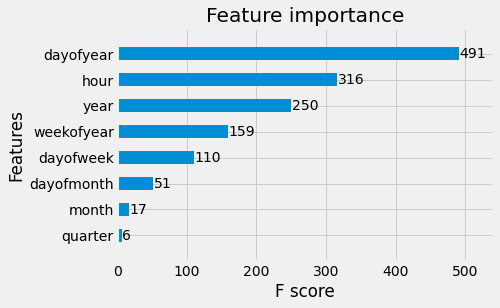

In [20]:
plot_importance(reg, height = 0.5)

In [21]:
pjme_test['MW_Prediction'] = reg.predict(x_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

<ipython-input-21-718a3d9e5890>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction'] = reg.predict(x_test)


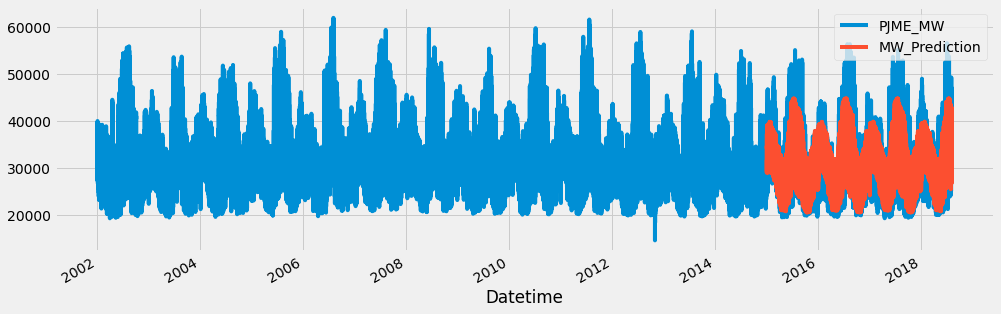

In [22]:
pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

#### First Month of Prediction

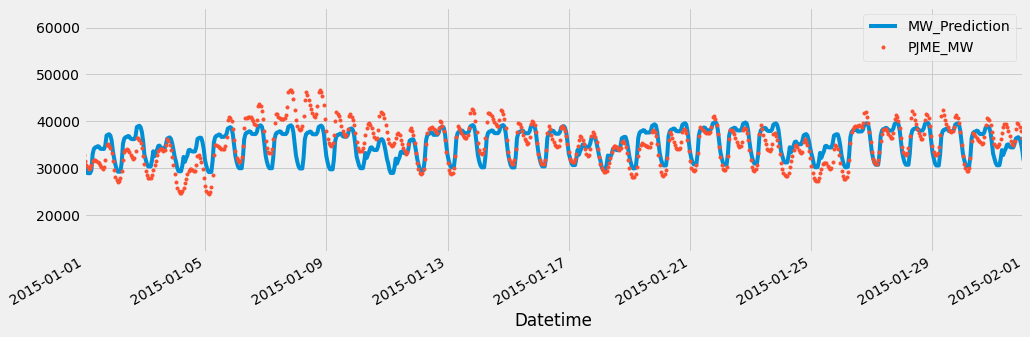

In [23]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')

#### First week of January

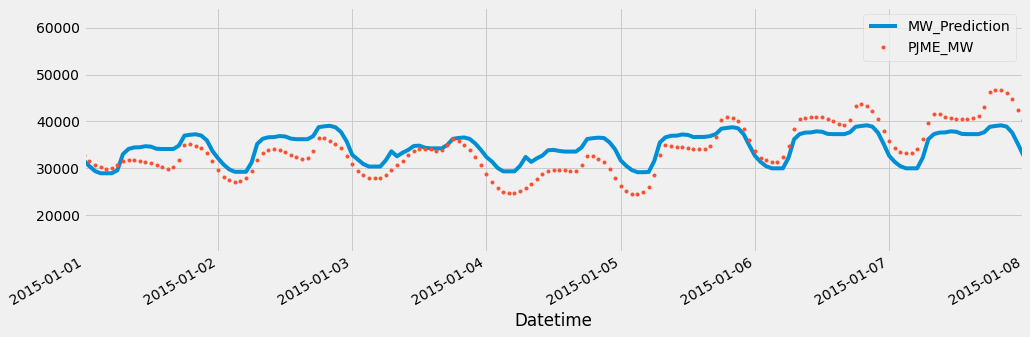

In [24]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')

#### First Week of July 

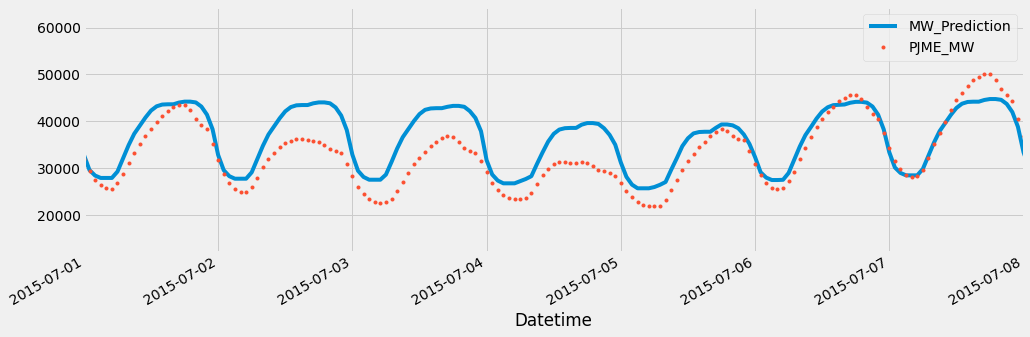

In [25]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')

#### Error Metrics

In [26]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

13780047.921846451

In [27]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2848.8312333512245

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.94924705409773

#### Analysis of worst and best predicted days

In [29]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)

<ipython-input-29-ef8a95843d13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
<ipython-input-29-ef8a95843d13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)


In [30]:
error_by_day = pjme_test.groupby(['year','month','dayofmonth']).mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [31]:
error_by_day.head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 1     1           31765.583333   33454.597656 -1689.013672  2361.785807
           2           32141.166667   35046.992188 -2905.825928  2905.825928
           3           32014.375000   33691.515625 -1677.139323  1677.712891
           4           28542.291667   33044.437500 -4502.144694  4502.144694
           5           33176.125000   35088.707031 -1912.583659  2742.250000
           6           38358.833333   35707.457031  2651.376709  2651.376709
           7           40181.875000   35707.457031  4474.418376  4474.418376
           8           42445.375000   35665.062500  6780.314209  6780.314209
           9           38524.666667   35270.156250  3254.512370  3254.512370
           10          37703.583333   33322.996094  4380.588704  4380.588704

##### Over feorecasted days

In [32]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36986.960938 -8587.002360  8587.002360
2017 2     24          26445.083333   33814.460938 -7369.376953  7369.376953
2015 12    25          24466.083333   31584.921875 -7118.839193  7118.839193
2017 2     20          27070.583333   34100.742188 -7030.159342  7030.159342
2015 7     3           30024.875000   37021.023438 -6996.149007  6996.149007
2017 6     28          30531.208333   37526.562500 -6995.355794  6995.355794
     2     8           28523.833333   35511.667969 -6987.835368  6987.835368
     9     2           24201.458333   31180.398438 -6978.940430  6978.940430
     2     25          24344.458333   31284.263672 -6939.806152  6939.806152
2018 2     21          27572.500000   34477.386719 -6904.885091  6904.885091

We can see,
1st worst day: 4th July,2016 - Holiday
3rd worst day: 25th December,2015 - Christmas
5th worst day: 4th July,2016 - Holiday

We should consider holidays in our analysis.

##### Worst Absolute Predicted days

In [33]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31753.242188  13432.591227  13432.591227
           14          44427.333333   31058.837891  13368.495524  13368.495524
     9     10          40996.166667   29786.183594  11209.982829  11209.982829
           9           43836.958333   32831.035156  11005.922852  11005.922852
2015 2     20          44694.041667   33814.460938  10879.581380  10879.581380
2018 1     6           43565.750000   33435.257812  10130.490397  10130.490397
2016 8     12          45724.708333   35609.328125  10115.380452  10115.380452
2017 5     19          38032.583333   28108.943359   9923.640218   9923.640218
     12    31          39016.000000   29314.707031   9701.293945   9701.293945
2015 2     21          40918.666667   31284.263672   9634.402181   9634.402181

##### Best Absolute Predicted days

In [34]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 10    3           27705.583333   27775.359375  -69.775879  229.586589
2015 10    28          28500.958333   28160.878906  340.079264  388.022298
2016 10    8           25183.333333   25535.677734 -352.343506  401.022705
     5     1           24503.625000   24795.404297 -291.779053  428.287842
2017 10    29          24605.666667   24776.281250 -170.614421  474.636068
2016 9     16          29258.500000   29397.277344 -138.776774  491.074463
     3     20          27989.416667   27620.197266  369.220133  499.709717
     10    2           24659.083333   25134.929688 -475.846924  516.198812
2017 10    14          24949.583333   25399.736328 -450.153076  520.862223
2015 5     6           28948.666667   28710.248047  238.419027  546.657145

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may.

#### Plotting Best/Worst predicted Days

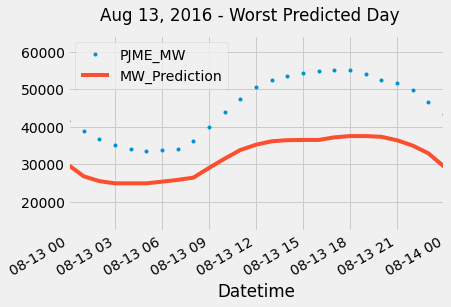

In [35]:
_, ax = plt.subplots(1)
pjme_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['.','-'])
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

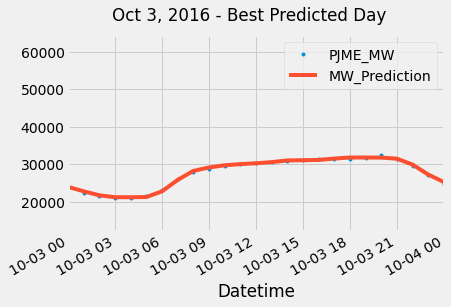

In [36]:
_, ax = plt.subplots(1)
pjme_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['.','-'])
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

## Linear model

In [37]:
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso, HuberRegressor
reg=LinearRegression(fit_intercept=False)
reg.fit(x_train, y_train)

LinearRegression(fit_intercept=False)

In [38]:
reg.coef_

array([[ 4.62331140e+02, -6.15994955e+02, -2.46449932e+02,
        -8.72852839e+03,  1.90911294e+01,  2.86767207e+02,
        -2.84673613e+02,  1.99219116e-01]])

In [39]:
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_lin'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_lin'])

0.2049801176374011


<ipython-input-39-9645a8731533>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction_lin'] = reg.predict(x_test)


15.525948231001937

In [40]:
from sklearn.neighbors import KNeighborsRegressor
#https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression
reg = KNeighborsRegressor(n_neighbors=4)
reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_knn'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_knn'])

0.43800296698928287


<ipython-input-40-479a324c830b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction_knn'] = reg.predict(x_test)


11.468180182880443

In [41]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=50, random_state=0)
reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_rfr'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_rfr'])

<ipython-input-41-20812fefef2b>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(x_train, y_train)


0.5564512284355667


<ipython-input-41-20812fefef2b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction_rfr'] = reg.predict(x_test)


9.834870999124446

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor


# Training Regressors
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(max_depth=50, random_state=1)
reg3 = KNeighborsRegressor(n_neighbors=3)
reg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
reg = reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_Grad'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_Grad'])

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6165275876714758


<ipython-input-42-e96197f5ea42>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction_Grad'] = reg.predict(x_test)


9.43474424978312

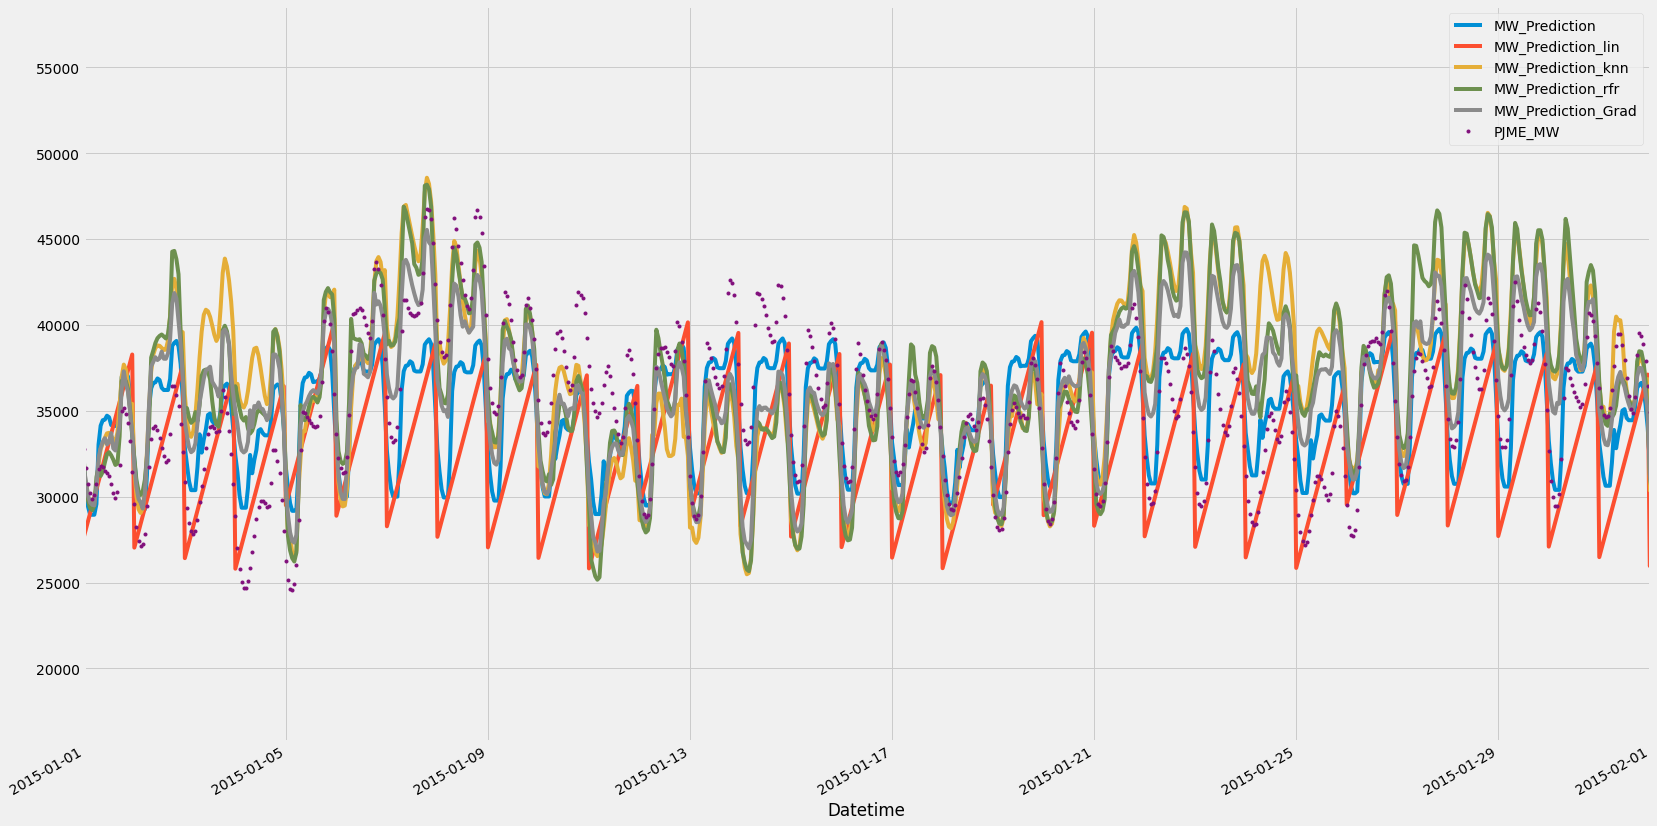

In [43]:
_, ax = plt.subplots(1)
pjme_test[['MW_Prediction', 'MW_Prediction_lin','MW_Prediction_knn','MW_Prediction_rfr','MW_Prediction_Grad','PJME_MW']].plot(ax=ax, style=['-','-','-','-','-','.'],figsize=(25, 15))
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')